In [1]:
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# Path to dialog's csv

csv_path = f"data/dialogs/{input('Enter dialog id: ')}.csv"

Enter dialog id: 594508393


In [3]:
plot_data = {}

In [5]:
# Loading csv to pandas DataFrame

data = pd.read_csv(csv_path)
data

,Unnamed: 0,id,date,from_id,to_id,fwd_from,message
0,0,41838,2020-08-12 18:50:50+00:00,594508393,418590848,NaN,NaN
1,1,41812,2020-08-12 18:20:11+00:00,594508393,418590848,NaN,Ахах
2,2,41806,2020-08-12 18:18:55+00:00,594508393,418590848,NaN,))))))
3,3,41805,2020-08-12 18:18:53+00:00,594508393,418590848,"MessageFwdHeader(date=datetime.datetime(2020, ...",Некоторые стесняются
4,4,41804,2020-08-12 18:18:53+00:00,594508393,418590848,NaN,Настільки що будуть слухати лекцію на німо
...,...,...,...,...,...,...,...
10915,10915,283,2018-04-19 18:39:35+00:00,594508393,418590848,NaN,NaN
10916,10916,282,2018-04-19 18:17:47+00:00,594508393,418590848,NaN,far cry 5 це просто топ
10917,10917,281,2018-04-19 08:56:25+00:00,594508393,418590848,NaN,NaN
10918,10918,280,2018-04-19 08:53:46+00:00,418590848,594508393,NaN,NaN


In [6]:
# Counting messages throughout hours.

for x in data.index:
    if not plot_data.get(data['date'][x][11:13]):
        plot_data.setdefault(data['date'][x][11:13], 1)
    else:
        plot_data[data['date'][x][11:13]] += 1

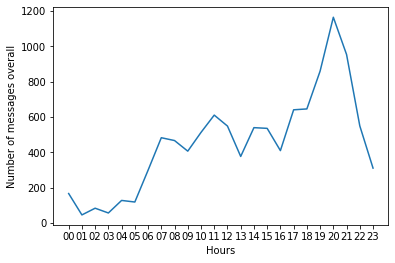

In [7]:
# Ploting data

lists = sorted(plot_data.items())
x, y = zip(*lists)


plt.plot(x, y)
plt.xlabel('Hours')
plt.ylabel('Number of messages overall')
plt.show()





In [ ]:
from messages_per_hours